In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import shap

import pe_utils as helper

import matplotlib as mpl
import matplotlib.pyplot as plt


import seaborn as sns
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':400, 'axes.linewidth':0.5,
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size} # 'figure.figsize':(11.7/1.5,8.27/1.5)

sns.set(style='ticks',rc=rc) #talk, ticks, paper
sns.set_context("paper")

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False # negative minus sign
plt.rcParams['axes.grid'] = False

In [5]:
sns.color_palette("hls", 20)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5272, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.86, 0.8392000000000002, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.42320000000000013),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.7352000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.6727999999999997, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.33999999999999997, 0.36079999999999973, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7767999999999993),
 (0.86, 0.33999999999999997, 0.6207999999999999),
 (0.86, 0.33999999999999997, 0.46479999999999977)]

In [8]:
colrs = sns.color_palette("hls", 20).as_hex()[:]

In [9]:
dict(zip(list(range(20)),colrs))

{0: '#db5f57',
 1: '#db8657',
 2: '#dbae57',
 3: '#dbd657',
 4: '#b9db57',
 5: '#91db57',
 6: '#69db57',
 7: '#57db6c',
 8: '#57db94',
 9: '#57dbbb',
 10: '#57d3db',
 11: '#57acdb',
 12: '#5784db',
 13: '#575cdb',
 14: '#7957db',
 15: '#a157db',
 16: '#c957db',
 17: '#db57c6',
 18: '#db579e',
 19: '#db5777'}

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor='white')

%matplotlib inline

scanpy==1.8.2 anndata==0.7.8 umap==0.5.3 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 pynndescent==0.5.7


In [4]:
import pickle
with open('results.pkl','rb') as f:
    res = pickle.load(f)

In [5]:
len_keys = len(res.keys())

In [6]:
from sklearn import metrics
# from numpy.random import randint
# from numpy.random import seed
# seed(1)
from sklearn.utils import resample
# from sklearn.model_selection import LeavePOut

perm_val=dict()

perm_auc_val=dict()
c_type=[]
sen=[]
spe=[]
npv=[]
ppv=[]

cc_type=[]
opt_thre_all=[]
auc_all=[]

for kkey in res:
    i_x_test=res[kkey]['pd_X_te']
    i_y_test=res[kkey]['y_te']
    i_model=res[kkey]['best_model']
    
    i_len=len(i_y_test)
    
    sen_all=[]
    spe_all=[]
    npv_all=[]
    ppv_all=[]
    
    c_type.append(kkey)
    
    for i in range(1,101):
        ii_x,ii_y=resample(i_x_test, i_y_test,n_samples=i_len, stratify=i_y_test, random_state=i+42)
        ii_y_predp = i_model.predict_proba(ii_x)[:,1]
        i_fpr, i_tpr, i_thre = metrics.roc_curve(ii_y, ii_y_predp)
        
        J = i_tpr-i_fpr
        ix = np.argmax(J)
        opt_thre = i_thre[ix]
        opt_thre_all.append(opt_thre)
        
        i_auc = metrics.auc(i_fpr, i_tpr)
        auc_all.append(i_auc)
        
        cc_type.append(kkey)
        
        ii_y_pred = np.where(ii_y_predp<opt_thre, 0, 1)
        
        tn, fp, fn, tp = metrics.confusion_matrix(ii_y, ii_y_pred).ravel()
#         print(tn, fp, fn, tp)
#         print(tp+fn,tn+fp, fn+tn,tp+fp)
        sen_all.append(tp/(tp+fn))
        spe_all.append(tn/(tn+fp))
        npv_all.append(tn/(fn+tn))
        ppv_all.append(tp/(tp+fp))
    
    avg_sen=np.array(sen_all).mean()
    std_sen=np.array(sen_all).std()
    
    avg_spe=np.array(spe_all).mean()
    std_spe=np.array(spe_all).std()
    
    avg_npv=np.array(npv_all).mean()
    std_npv=np.array(npv_all).std()
    
    avg_ppv=np.array(ppv_all).mean()
    std_ppv=np.array(ppv_all).std()
    
    sen.append(r'{0:.3f}$\pm${1:.3f}'.format(avg_sen, std_sen))
    spe.append(r'{0:.3f}$\pm${1:.3f}'.format(avg_spe, std_spe))
    npv.append(r'{0:.3f}$\pm${1:.3f}'.format(avg_npv, std_npv))
    ppv.append(r'{0:.3f}$\pm${1:.3f}'.format(avg_ppv, std_ppv))
perm_val['Type']=c_type    
perm_val['SEN']=sen
perm_val['SPE']=spe
perm_val['NPV']=npv
perm_val['PPV']=ppv

perm_auc_val['Type']=cc_type
perm_auc_val['AUC']=auc_all
perm_auc_val['THRE']=opt_thre_all


    

In [7]:
perm_f = pd.DataFrame(perm_val)
perm_f.to_csv('pseudo10_perm.csv',index=False)

In [9]:
perm_auc_f = pd.DataFrame(perm_auc_val)

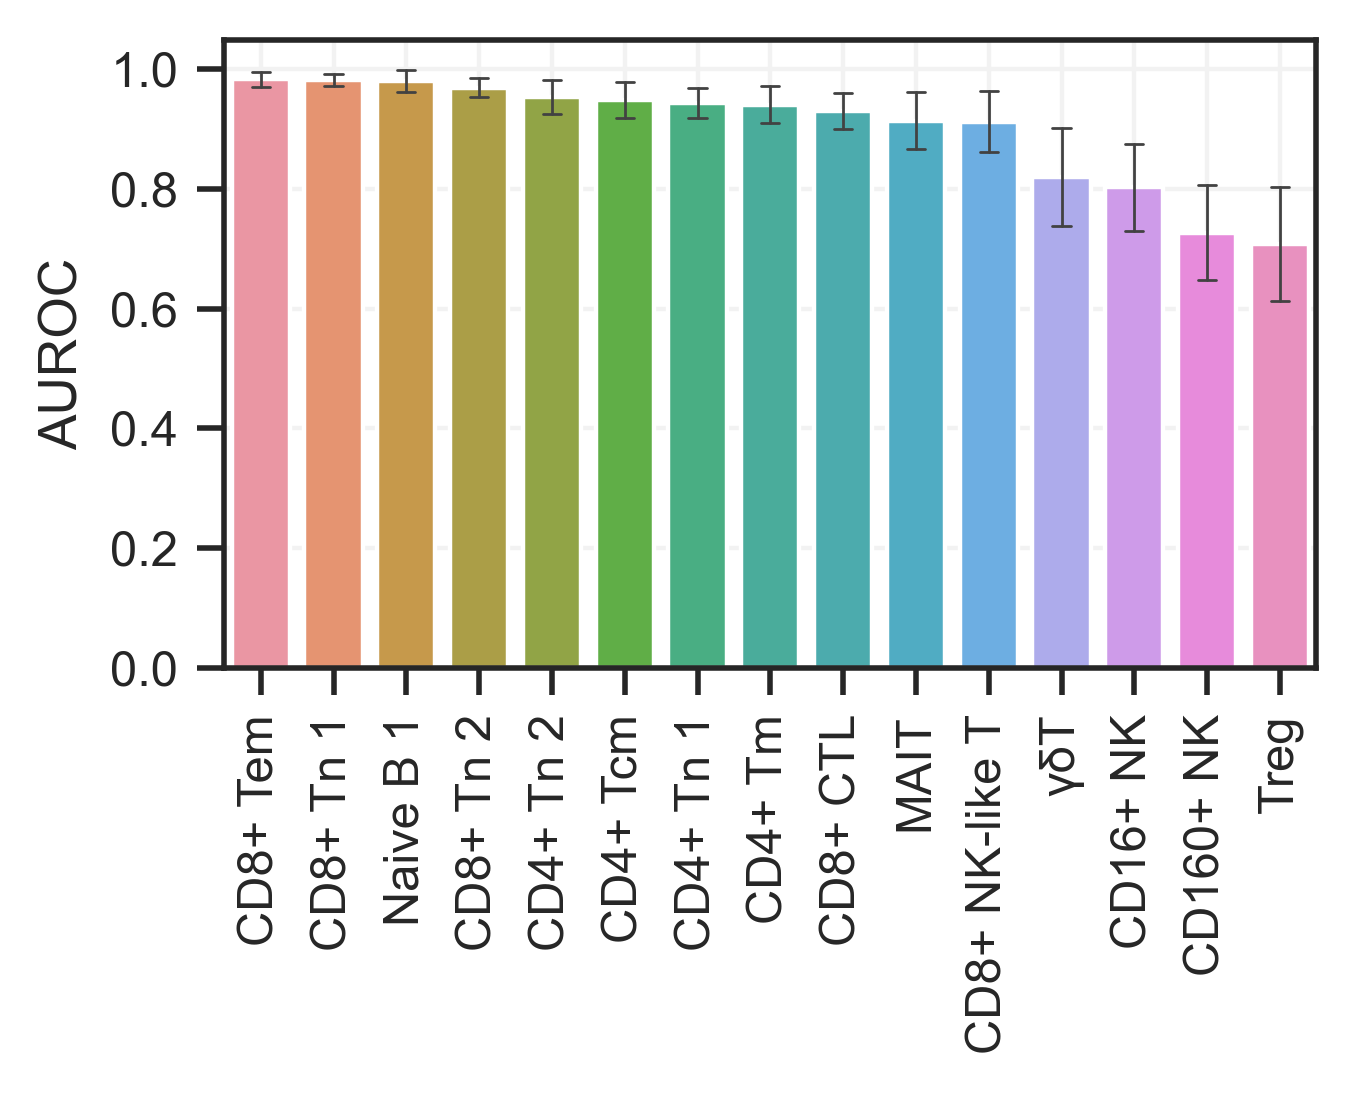

In [12]:
sort_va = perm_auc_f.groupby(["Type"])['AUC'].aggregate(np.mean).reset_index().sort_values('AUC',ascending=False)
result = perm_auc_f.groupby(["Type"])['AUC'].aggregate(np.mean).reset_index().sort_values('AUC')
fig, axs = plt.subplots(1,1,figsize=(3.5,2))
sns.barplot(data=perm_auc_f, x='Type',y='AUC',ci='sd', 
            capsize=0.25,errwidth=0.5,order=sort_va['Type'],ax=axs)
# axs.tick_params(direction='out', length=3, pad=1, width=1)
plt.xticks(rotation=90)
plt.grid(color='0.95')
plt.xlabel('')
plt.ylabel('AUROC')
plt.savefig("auc-pseudo10.jpg", dpi=400, bbox_inches='tight', format='jpg')


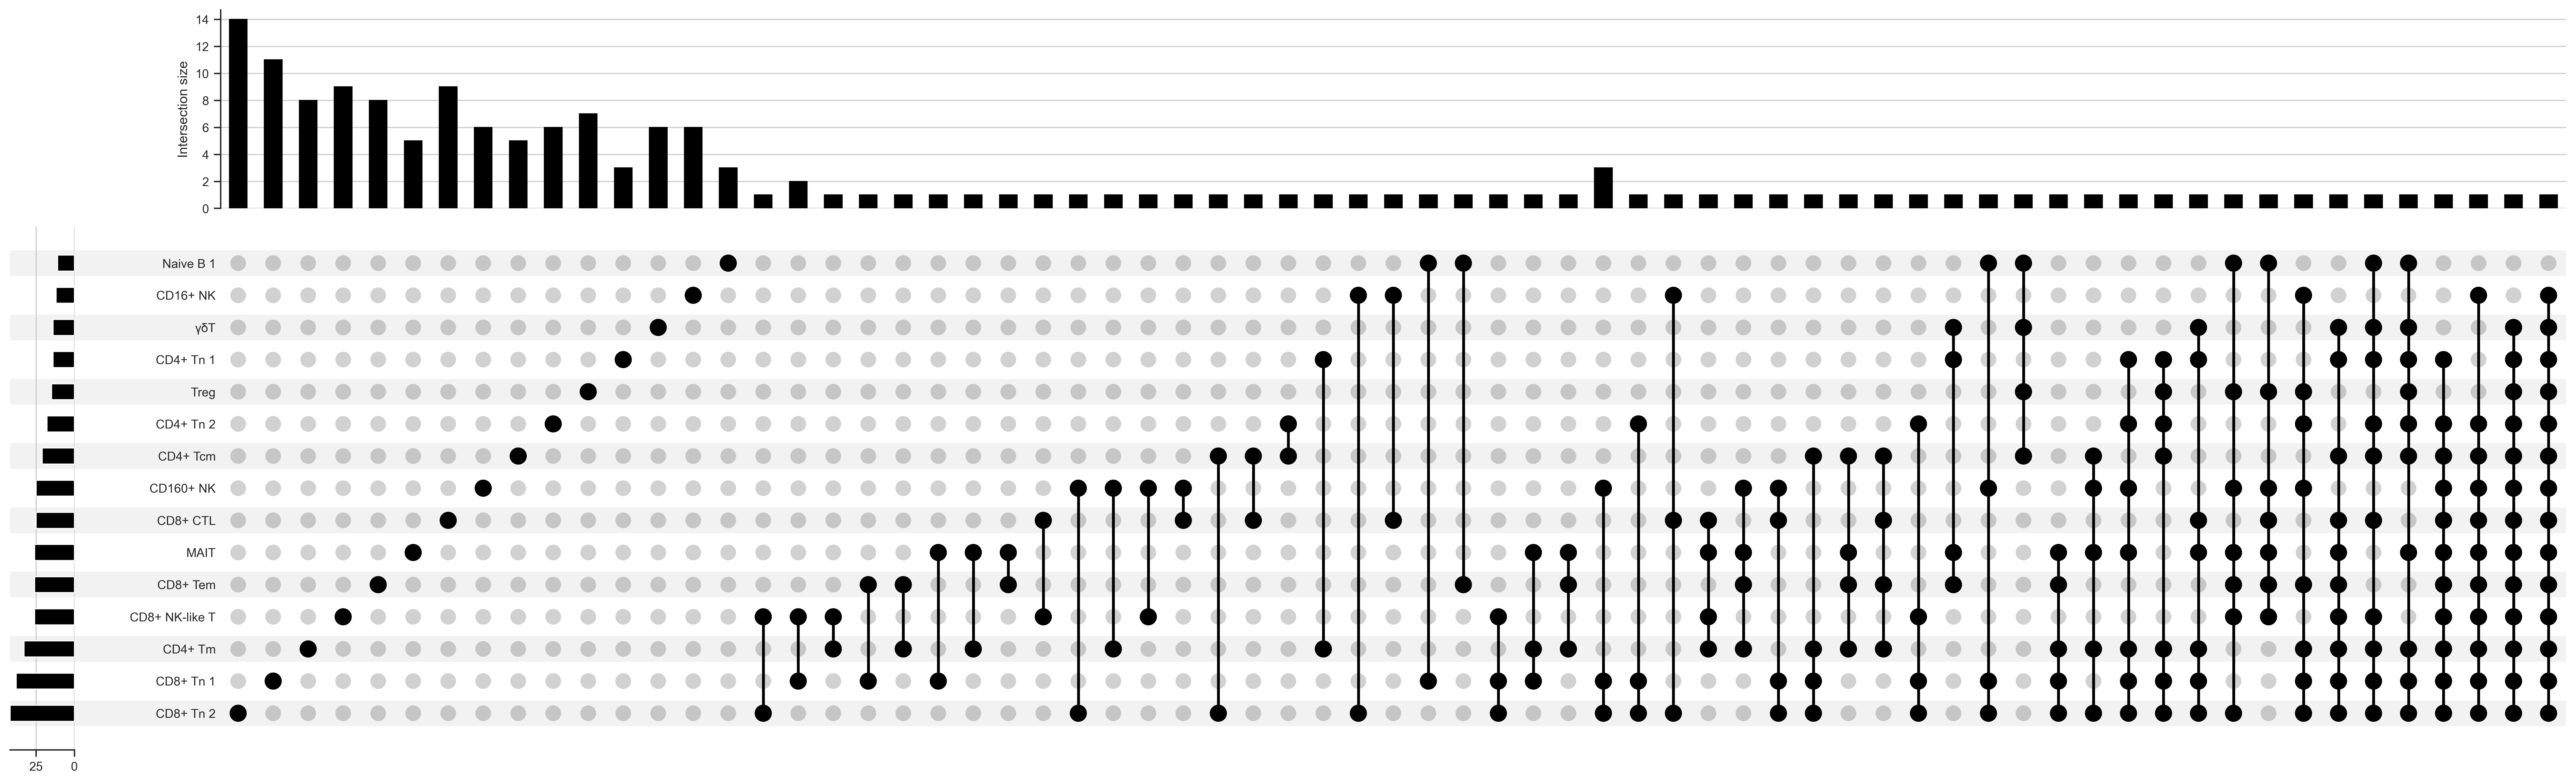

In [13]:
import upsetplot
feat_dicts=dict()
for kkey in res:
    feat_dicts[kkey]=res[kkey]['feat_list']
upset_data_sub = upsetplot.from_contents(feat_dicts)
upsetplot.plot(upset_data_sub)
plt.savefig("gene_intersection-pseudo-10.jpg", dpi=400, bbox_inches='tight', format='jpg')

In [62]:
from sklearn import metrics
# from numpy.random import randint
# from numpy.random import seed
# seed(1)
# from sklearn.utils import resample
from sklearn.model_selection import LeaveOneOut

perm_val=dict()
c_type=[]
sen=[]
spe=[]
npv=[]
ppv=[]
mAUC=[]
sAUC=[]

for kkey in res:
    i_x_test=res[kkey]['pd_X_te']
    i_y_test=res[kkey]['y_te']
    i_model=res[kkey]['best_model']
    
    i_len=len(i_y_test)

    auc_all=[]
    
    sen_all=[]
    spe_all=[]
    npv_all=[]
    ppv_all=[]
    
    perm_val['Type']=c_type.append(kkey)
    
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(i_x_test):
        ii_x = i_x_test.iloc[train_index,:]
        ii_y = i_y_test[train_index]
#     for i in range(100):
#         # bootstrap sample
# #         indices = randint(0, i_len, i_len)
# #         ii_x = i_x_test.iloc[indices,:]
# #         ii_y = i_y_test[indices]
#         ii_x, ii_y = resample(i_x_test, i_y_test, random_state=i+10, n_samples=i_len*10, stratify=i_y_test)
    
        ii_y_predp = i_model.predict_proba(ii_x)[:,1]
        ii_y_pred = np.where(ii_y_predp<0.3, 0, 1)

        i_fpr, i_tpr, i_thre = metrics.roc_curve(ii_y, ii_y_predp)
        i_auc = metrics.auc(i_fpr, i_tpr)
        auc_all.append(i_auc)
        
        tn, fp, fn, tp = metrics.confusion_matrix(ii_y, ii_y_pred).ravel()
#         print(tn, fp, fn, tp)
#         print(tp+fn,tn+fp, fn+tn,tp+fp)
        sen_all.append(tp/(tp+fn))
        spe_all.append(tn/(tn+fp))
        npv_all.append(tn/(fn+tn))
        ppv_all.append(tp/(tp+fp))
    
    avg_auc=np.array(auc_all).mean()
    std_auc=np.array(auc_all).std()
    
    avg_sen=np.array(sen_all).mean()
    std_sen=np.array(sen_all).std()
    
    avg_spe=np.array(spe_all).mean()
    std_spe=np.array(spe_all).std()
    
    avg_npv=np.array(npv_all).mean()
    std_npv=np.array(npv_all).std()
    
    avg_ppv=np.array(ppv_all).mean()
    std_ppv=np.array(ppv_all).std()
    
    perm_val['avg_AUC']=mAUC.append(avg_auc)
    perm_val['std_AUC']=sAUC.append(std_auc)
    
    perm_val['SEN']=sen.append(r'{0:.3f}$\pm${1:.3f}'.format(avg_sen, std_sen))
    perm_val['SPE']=spe.append(r'{0:.3f}$\pm${1:.3f}'.format(avg_spe, std_spe))
    perm_val['NPV']=npv.append(r'{0:.3f}$\pm${1:.3f}'.format(avg_npv, std_npv))
    perm_val['PPV']=ppv.append(r'{0:.3f}$\pm${1:.3f}'.format(avg_ppv, std_ppv))
    

In [63]:
sen

['1.000$\\pm$0.000',
 '1.000$\\pm$0.000',
 '0.909$\\pm$0.012',
 '0.933$\\pm$0.009',
 '0.867$\\pm$0.012',
 '0.923$\\pm$0.010',
 '0.929$\\pm$0.010',
 '0.727$\\pm$0.021',
 '0.909$\\pm$0.013',
 '0.833$\\pm$0.017',
 '0.333$\\pm$0.035',
 '1.000$\\pm$0.000',
 '0.600$\\pm$0.049',
 '0.800$\\pm$0.041',
 '0.500$\\pm$0.038']

In [32]:
perm_val

{'Type': None,
 'avg_AUC': None,
 'std_AUC': None,
 'SEN': None,
 'SPE': None,
 'NPV': None,
 'PPV': None}

In [6]:
np.array(auc_all).std()

0.009620457212238191

In [14]:
def tst_roc(res):
    
    from sklearn import metrics
    
    mean_fpr = np.linspace(0, 1, 500)
    
    auc_re=dict()
    
    for kkey in res:
        ipred=dict()
        
        i_y_tst_true = res[kkey]['y_te']
        i_y_tst_pred = res[kkey]['test_res']
        
        i_fpr, i_tpr, i_thre = metrics.roc_curve(i_y_tst_true, i_y_tst_pred) #drop_intermediate=False)
        
        i_auc = metrics.auc(i_fpr, i_tpr)
        
        interp_tpr = np.interp(mean_fpr, i_fpr, i_tpr)
        interp_tpr[0] = 0.0
        
        interp_thres = np.interp(mean_fpr, i_fpr, i_thre)
        
        ipred['tpr']=interp_tpr
        ipred['fpr']=mean_fpr
        ipred['thre']=interp_thres
        ipred['auc']=i_auc
        
        auc_re[kkey]=ipred
    
    return auc_re

# AUC
auc = tst_roc(res)

meta NOT subset; don't know how to subset; dropped


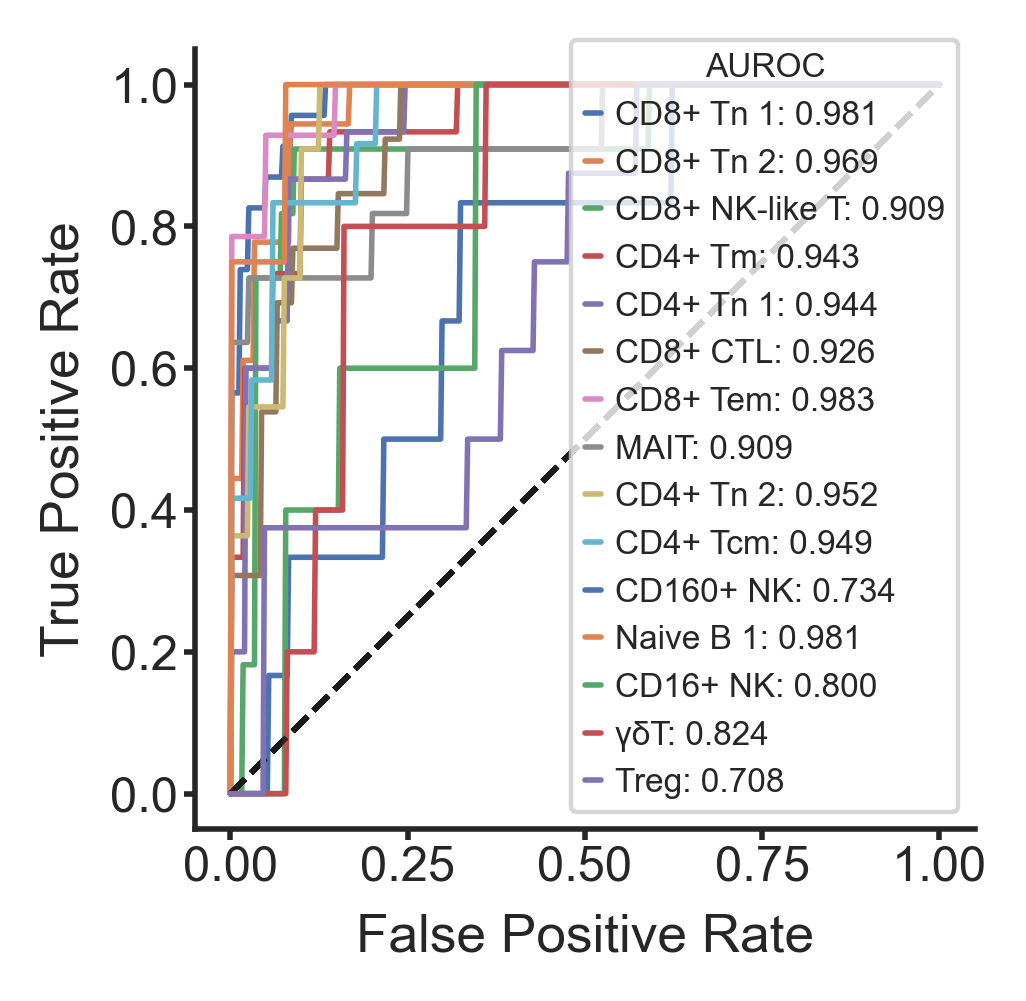

In [19]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))

for k in auc:
    i_tpr = auc[k]['tpr']
    i_fpr = auc[k]['fpr']
    i_thre = auc[k]['thre']
    i_auc = auc[k]['auc']
    
    ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color="k", alpha=0.8)
    lb = k + ': '+r'{0:.3f}'.format(i_auc)
    
    ax.plot(i_fpr, i_tpr, label='{0}'.format(lb), lw=1)
    
ax.set(xlim=[-0.05, 1.05],ylim=[-0.05, 1.05])
sns.despine()
ax.set_aspect('equal','box')
ax.legend(loc="lower right",title='AUROC',title_fontsize=6,fontsize=6)#,frameon=False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.tick_params(direction='out', length=2, pad=1, width=1)   

plt.savefig("auc.pdf", dpi=400, bbox_inches='tight', pad_inches = 0.1)